In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from dataset.LFWDataset import *
from torchvision.transforms import v2
from model.UNET import *

Load the model's weights

In [83]:
model=UNet(n_channels=3,n_classes=3)
model.load_state_dict(torch.load('D:\\UBB\\CVDL\\Project\\model\\model6.pth'))
temperature=0.3
def get_mask2(img,model):
    model.eval()
    img=img.unsqueeze(0)
    with torch.no_grad():
        mask=model(img)
        mask=mask.squeeze(0).detach()
        mask=mask.permute(1,2,0)
        return mask
def get_mask(img,model):
    model.eval()
    with torch.no_grad():
        img=img.unsqueeze(0)
        mask=model(img)
        #interpolate mask to img sizes
        mask = F.interpolate(mask, size=(img.size(-2), img.size(-1)), mode='bilinear', align_corners=True)
        #apply sigmoid to the values of the mask
        mask=torch.sigmoid(mask)
        mask=mask.squeeze(0)
        mask=mask.permute(1,2,0)

        mask[mask>=temperature]=1
        mask[mask<temperature]=0
        mask=mask.cpu().numpy()

        return mask     

Load picture of woman

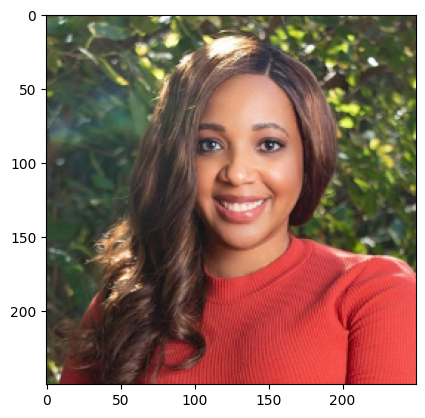

In [84]:
image_sample=cv2.imread('images/woman.jpg')
image_sample=cv2.cvtColor(image_sample,cv2.COLOR_BGR2RGB)
image_sample = cv2.resize(image_sample,(250,250))

plt.imshow(image_sample)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([250, 250, 3])


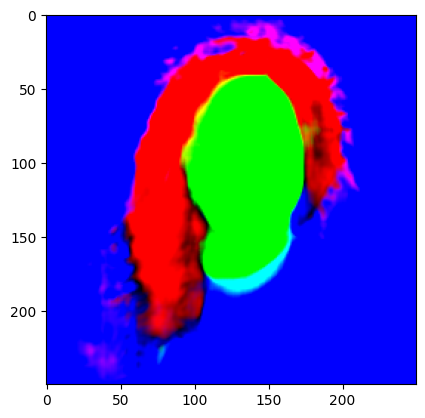

In [85]:

image_sample=v2.ToTensor()(image_sample)
mask=get_mask2(image_sample,model)
#mask=mask.argmax(2)
#plt.imshow(mask)

plt.imshow(mask)
print(mask.shape)

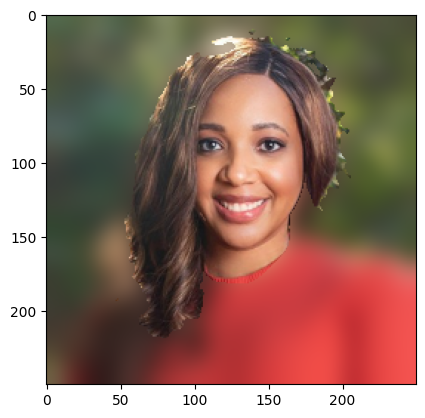

In [86]:
def blur_background(mask,image):
    mask=mask.argmax(2)
    blurred_image=np.copy(image)
    blurred_image=blurred_image.astype(float)
    blurred_image=np.transpose(blurred_image,(1,2,0))
    background_mask = mask==2
    blurred_background=cv2.GaussianBlur(blurred_image,(51,51),0)
    blurred_image[background_mask]=blurred_background[background_mask]
                    
    return blurred_image




blurred_image=blur_background(mask,image_sample)
plt.imshow(blurred_image)


In [2]:
dataset=LFWDataset(download=False, base_folder='D:\\UBB\\CVDL\\Project\\dataset\\lfw_dataset', transforms=v2.Compose([
                                                            v2.Resize(256),
                                                            v2.CenterCrop(224),
                                                            v2.ToTensor()]))

c:\Users\denis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


torch.Size([3, 250, 250])


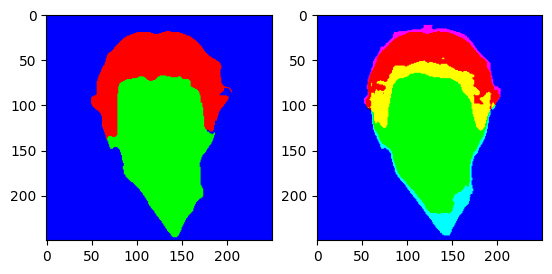

In [87]:

with torch.no_grad():
    first_img=dataset[0][0]
    first_img_mask=dataset[0][1]
    print(first_img.shape)


    first_img=first_img.unsqueeze(0)
    mask=model(first_img)
    mask=mask.squeeze(0)
    mask=mask.permute(1,2,0)
    mask[mask>0]=1
    mask[mask<=0]=0
    mask=mask.detach().numpy()
    first_img=first_img.squeeze(0)

    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(first_img_mask.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(mask)


#print(mask)






In [5]:
def mpa(preds, masks):
    preds = preds.argmax(dim=1).reshape(-1)
    masks = masks.argmax(dim=1).reshape(-1)

    correct_pixels = torch.sum(preds == masks)
    total_pixels = len(preds)
    pixel_acc = correct_pixels / total_pixels

    return pixel_acc

def iou(preds, masks):
    flat_preds = preds.argmax(dim=1).reshape(-1)
    flat_masks = masks.argmax(dim=1).reshape(-1)
    intersection = torch.sum(flat_preds == flat_masks)

    gt_pixels = torch.sum(torch.ones_like(masks.argmax(dim=1)))
    pred_pixels = torch.sum(torch.ones_like(preds.argmax(dim=1)))

    return intersection / (gt_pixels + pred_pixels - intersection)

def weighted_iou(preds, masks):
    flat_preds = preds.argmax(dim=1).reshape(-1)
    flat_masks = masks.argmax(dim=1).reshape(-1)
    intersection = torch.sum(flat_preds == flat_masks)

    gt_pixels = torch.sum(torch.ones_like(masks.argmax(dim=1)))
    pred_pixels = torch.sum(torch.ones_like(preds.argmax(dim=1)))

    union = gt_pixels + pred_pixels - intersection

    # Calculate class frequencies
    class_freqs = torch.bincount(masks.argmax(dim=1).reshape(-1), minlength=3)  

    # Calculate frequency-weighted IoU
    weights = 1 / (class_freqs.float() + 1)  # Add 1 to avoid division by zero
    weighted_iou = (intersection / union) * (weights[1] + weights[2])

    return weighted_iou


model=UNet(n_channels=3,n_classes=3)
model.load_state_dict(torch.load('D:\\UBB\\CVDL\\Project\\model\\model6.pth'))

model.eval()
pixel_accs = []
ious = []
weighted_ious = []

for i in range(10):
    img, mask = dataset[i]
    img = img.unsqueeze(0)
    mask = mask.unsqueeze(0)

    with torch.no_grad():
        pred = model(img)
        pixel_acc = mpa(pred, mask)
        iou_score = iou(pred, mask)
        weighted_iou_score = weighted_iou(pred, mask)

    pixel_accs.append(pixel_acc)
    ious.append(iou_score)
    weighted_ious.append(weighted_iou_score)

pixel_acc = torch.mean(torch.stack(pixel_accs))
iou = torch.mean(torch.stack(ious))
weighted_iou = torch.mean(torch.stack(weighted_ious))

print(f'Pixel accuracy: {pixel_acc}')
print(f'IoU: {iou}')
print(f'Weighted IoU: {weighted_iou}')



torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
torch.Size([1, 3, 250, 250])
Pixel accuracy: 0.9506111145019531
IoU: 0.9064699411392212
Weighted IoU: 8.844179683364928e-05
